# Бейзлайны и детерминированные алгоритмы item-item

In [1]:
!pip install implicit

     |████████████████████████████████| 1.1MB 12.6MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419515 sha256=284b98b64b05f9cdaa964af5d4b9da2129c90cb67195da0e91da6c8c6cf4b87f
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

from google.colab import files

In [4]:
file = files.upload()

Saving predictions_basic.csv to predictions_basic.csv


In [5]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


In [7]:
data.loc[(data['user_id'] == 2375) & (data['basket_id'] == 26984851472)]['item_id'].max()

8160430

In [8]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

# Задание 0.
## Товар 999999

На вебинаре мы использовали товар 999999 - это товар, который купили пользователи, если они не купили товар из top5000. Используя этот товар мы смещяем качество рекомендаций. В какую сторону? Уберите этот товар и сравните с качеством на семинаре.

C товаром 999999:

random 0.0008814887365328109

popular_recommendation 0.15523996082272082

itemitem 0.13692458374142857

cosine 0.13290891283055686

tfidf 0.1389813907933383

own_purchases 0.17969311132876015

## Без него:

random_recommendation 0.006889564336372838

popular_recommendation 0.1605876393110415

itemitem 0.16028368794326048

cosine 0.15947315096251063

tfidf 0.16372847011144678

own_purchases 0.22687436676798098

Без него все улучшилось. tfidf потеснил популярные рекомендации.


### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [11]:
summa = np.log(data_train.groupby(['item_id'])['user_id'].count()).sum()

In [12]:
weights = np.log(data_train.groupby(['item_id'])['user_id'].count())/summa

# убедимся, что посчитали правильно вероятности

weights.sum().round(5) == 1

True

In [21]:
popular = data_train.groupby('item_id')['sales_value'].sum().reset_index()
popular.sort_values('sales_value', ascending=False, inplace=True)
popular.loc[popular['sales_value'] < 1, 'sales_value'] = 1
popular.sales_value = np.log(popular.sales_value)
sum_popular = popular.sales_value.sum()
popular.sales_value = popular.sales_value.apply(lambda x: x/sum_popular)
popular.columns = ['item_id', 'weight']

def weighted_random_recommendation(n):
    items = np.array(popular.item_id)
    weights = np.array(popular.weight)
    recs = np.random.choice(items, size=n, replace=False, p=weights)
    
    return recs.tolist()

popular

,item_id,weight
55470,6534178,0.000057
55430,6533889,0.000047
28895,1029743,0.000046
55465,6534166,0.000045
34707,1082185,0.000045
...,...,...
42020,1244713,0.000000
14575,900351,0.000000
54721,6424439,0.000000
63321,9296891,0.000000


In [22]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(n=5))


In [23]:
result.head(2)

,user_id,actual,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6602723, 1075793, 12731616, 1024489, 1077485]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[10344967, 9832529, 823677, 1112881, 1633508]"


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [24]:
predict = pd.read_csv('predictions_basic.csv')
predict.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[915613, 9677389, 14025347, 839358, 15452729]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[13115471, 7410369, 821766, 13447929, 5133283]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [25]:
import re

for col in predict.columns[1:]:
    predict[col] = [np.array(re.findall('\d+', x), dtype=np.uintc) for x in predict[col]]

In [26]:
predict.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[915613, 9677389, 14025347, 839358, 15452729]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13115471, 7410369, 821766, 13447929, 5133283]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [27]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_array = np.array(bought_list)

    recommended_array = np.array(recommended_list[:k])

    bought_array = bought_array  # Тут нет [:k] !!

    flags = np.isin(bought_array, recommended_array)

    precision = flags.sum() / recommended_array.shape[0]

    return precision

In [28]:
fact = predict['actual']
for col in predict.columns[2:]:
    list_ = []
    for rec, act in zip(predict[col],fact):
        list_.append(precision_at_k(rec, act, k=5))
    prec=pd.Series(list_).mean()
    print(f'Для модели {col} средний precision_at_k равен {prec}')

Для модели random_recommendation средний precision_at_k равен 0.0005876591576885406
Для модели popular_recommendation средний precision_at_k равен 0.15523996082272082
Для модели itemitem средний precision_at_k равен 0.13692458374142857
Для модели cosine средний precision_at_k равен 0.13290891283055686
Для модели tfidf средний precision_at_k равен 0.1389813907933383
Для модели own_purchases средний precision_at_k равен 0.17969311132876015


### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

In [29]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(15)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8..."
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884..."
7,14,"[840601, 867293, 933067, 951590, 952408, 96569..."
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13..."
9,16,"[1062973, 1082185, 13007710]"


In [30]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,25671,26081,26093,26190,26355,26426,26540,26601,26636,26691,26738,26889,26941,27021,27030,27152,27158,27159,27323,27334,27346,27404,27479,27491,27503,27509,27510,27522,27558,27633,27657,27658,27686,27695,27697,27732,27735,27745,27754,27760,...,17249003,17249285,17249614,17249651,17282500,17282612,17283027,17283348,17283671,17283763,17284209,17284296,17284297,17284346,17284401,17284423,17284629,17285065,17291184,17291554,17291665,17319084,17320591,17320698,17320734,17320911,17321083,17321092,17328261,17328345,17328742,17329473,17329749,17330255,17330511,17381856,17382205,17383227,17827644,17829232
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [33]:
def precision_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    return precision

def recall_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    flags = np.isin(bought_list, recommended_list)
    recall = flags.sum() / len(bought_list)
    return recall


itemitem 1 0.21949069539666716
itemitem 1 0.02916975462223123



itemitem 2 0.20626836434867468
itemitem 2 0.029707508389469926



itemitem 3 0.17002938295788222
itemitem 3 0.02243043671224846



itemitem 4 0.15102840352595306
itemitem 4 0.017728435300893314



itemitem 5 0.15406464250734386
itemitem 5 0.017071714547674758



itemitem 7 0.16415279138099706
itemitem 7 0.01780839664202439



itemitem 10 0.1669931439764916
itemitem 10 0.018261804550634447



itemitem 15 0.1670910871694397
itemitem 15 0.01819386498671496



itemitem 25 0.16758080313418014
itemitem 25 0.019129603044244936



itemitem 50 0.166405484818803
itemitem 50 0.019044093070202182


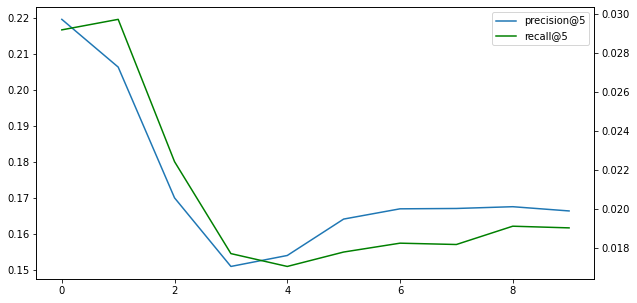

In [34]:
pre = []
rec = []

for i in (1, 2, 3, 4, 5, 7, 10, 15, 25, 50):
    model = ItemItemRecommender(K=i, num_threads=4) # K - кол-во билжайших соседей

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)

    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                            user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                            N=5, # кол-во рекомендаций 
                            filter_already_liked_items=False, 
                            filter_items=None, 
                            recalculate_user=True)

    result['itemitem'] = result['user_id'].\
        apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                        model.recommend(userid=userid_to_id[x], 
                                        user_items=sparse_user_item,   # на вход user-item matrix
                                        N=5, 
                                        filter_already_liked_items=False, 
                                        filter_items=None, 
                                        recalculate_user=True)])

    r = result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean()
    print('itemitem ' + str(i), r)
    pre.append(r)
    r = result.apply(lambda row: recall_at_k(row['itemitem'], row['actual']), axis=1).mean()
    print('itemitem ' + str(i), r)
    rec.append(r)
    
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
lns1 = ax.plot(pre, label='precision@5')
ax2 = ax.twinx()
lns2 = ax2.plot(rec, c='g', label='recall@5')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='upper right')
plt.show()